# Sales forecase assignment

You are provided with an attachment in .csv format for historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. 
These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. 

## Content

Within the Excel Sheet, there are 3 Tabs – **Stores**, **Features** and **Sales** 
- Tab 1: Stores (Anonymised information about the 45 stores, indicating the type and size of store) 
- Tab 2: Features (Contains additional data related to the store, department, and regional activity for the given dates.) 
- Tab 3: Sales (Historical sales data, which covers 2010-02-05 to 2012-11-01. Within this tab you will find the following fields) 

## Task

 1. Predict the department-wide sales for each store for the following year
 2. Model the effects of markdowns on holiday weeks
 3. Provide recommended actions based on the insights drawn, with prioritisation placed on largest business impact

# Solution

The solution to this task begins here.

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

### Import Data

In [2]:
#Read the 3 datasources
sales = pd.read_csv('sales data-set.csv')
features = pd.read_csv('Features data set.csv')
stores = pd.read_csv('stores data-set.csv')

### Peak at the Data

The goal of this step is to try and get an overview of the data we are dealing with, this can include:
- Data types
- Null & non-Null
- Columns and Rows

In [3]:
print("\n Stores:\n", stores.head())
print(stores.info())

print("\n Features:\n", features.head())
print(features.info())

print("\n Sales:\n", sales.head())
print(sales.info())


 Stores:
    Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None

 Features:
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0     

### Data Cleaning
From the previous step, we've found columns that need to be cleaned before they can be used in our analysis. It is worth noting that our algorithims only understand numbers; null, letters, and symbols are not useful hence we need to convert them into numbers is possible.

In [4]:
sales['Date'] = pd.to_datetime(sales['Date'])
features['Date'] = pd.to_datetime(features['Date'])

#Check the Rows, Columns of our data
print("Features: ", features.shape)
print("Sales: ", sales.shape)
print("Stores: ", stores.shape)

Features:  (8190, 12)
Sales:  (421570, 5)
Stores:  (45, 3)


/var/folders/r1/zb0pp1nj0bd0gh1rpz8l6ms00000gn/T/ipykernel_90606/4108912380.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales['Date'] = pd.to_datetime(sales['Date'])
/var/folders/r1/zb0pp1nj0bd0gh1rpz8l6ms00000gn/T/ipykernel_90606/4108912380.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  features['Date'] = pd.to_datetime(features['Date'])


### Merging the Data

In [5]:
#We merge the data and ensure that we keep all records from the Sales datasource, this works like an SQL Left join
df = pd.merge(sales, features, on = ['Store', 'Date', 'IsHoliday'], how ='left')
#Same here, the idea is we want to keep all records from df
df = pd.merge(df, stores, on = ['Store'], how = 'left')
#As mentioned in the "Data cleaning step", nulls are not useful in our analysis so we replace them with 0s
df = df.fillna(0)
#We want to factorize the Type and IsHoliday columns and replace each unique cateogorical value the column with a numerical code.
df[['Type', 'IsHoliday']] = df[['Type', 'IsHoliday']].apply(lambda x: pd.factorize(x)[0])
#Convert temperature from Fahrenheit to Celsius (Not needed but more relatable since we use Celcius)
df['Temperature'] = (df['Temperature']- 32) * 5./9.
#Split the date column into month, day, and year
df['month'] = df['Date'].apply(lambda i : i.month)
df['day'] = df['Date'].apply(lambda i : i.day)
df['year'] = df['Date'].apply(lambda i : i.year)

In [6]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month,day,year
0,1,1,2010-05-02,24924.50,0,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,0,151315,5,2,2010
1,1,1,2010-12-02,46039.49,1,3.616667,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,0,151315,12,2,2010
2,1,1,2010-02-19,41595.55,0,4.405556,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,0,151315,2,19,2010
3,1,1,2010-02-26,19403.54,0,8.127778,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,0,151315,2,26,2010
4,1,1,2010-05-03,21827.90,0,8.055556,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,0,151315,5,3,2010


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  int64         
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  int64         
 15  Size          421

In [8]:
df.shape

(421570, 19)

The describe() method provided by Pandas generates a statistical summary of the DataFrame df. It computes several common statistics for each numerical column in the DataFrame, including the count, mean, standard deviation, minimum value, 25th percentile, median (50th percentile), 75th percentile, and maximum value.

In [9]:
df.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month,day,year
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.589912,136727.915739,6.478580,15.644061,2010.968591
std,12.785297,30.492054,22711.183519,0.255750,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.666337,60980.583328,3.324757,8.753493,0.796876
min,1.000000,1.000000,-4988.940000,0.000000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.000000,34875.000000,1.000000,1.000000,2010.000000
25%,11.000000,18.000000,2079.650000,0.000000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.000000,93638.000000,4.000000,8.000000,2010.000000
50%,22.000000,37.000000,7612.030000,0.000000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.000000,140167.000000,6.000000,16.000000,2011.000000
75%,33.000000,74.000000,20205.852500,0.000000,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,1.000000,202505.000000,9.000000,23.000000,2012.000000
max,45.000000,99.000000,693099.360000,1.000000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2.000000,219622.000000,12.000000,31.000000,2012.000000


### Check for duplicates

In [10]:
df.duplicated().sum()
#Remove duplicates
df.drop_duplicates(inplace = True)

### Insight

In [11]:
#Number of unique stores
df['Store'].nunique()

45

In [12]:
#Number of unique departments
df['Dept'].nunique()

81

Visualize The proportion of total sales generated by each store type

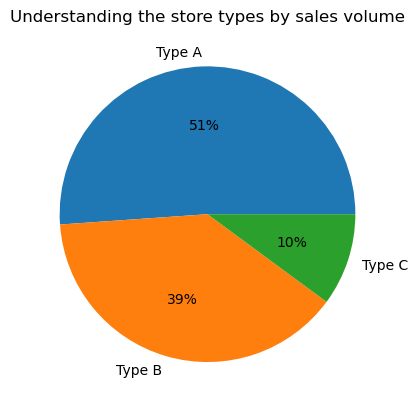

In [13]:
stores = ['Type A','Type B','Type C']
data = df['Type'].value_counts()
fig, ax = plt.subplots()
plt.pie(data, labels = stores,autopct='%.0f%%')
ax.set_title('Understanding the store types by sales volume')
# show plot
plt.show()

Looking at the distribution of shop sizes for each store category, we can see that store type A is the largest, shop type B is smaller than A, and store type C is the lowest.

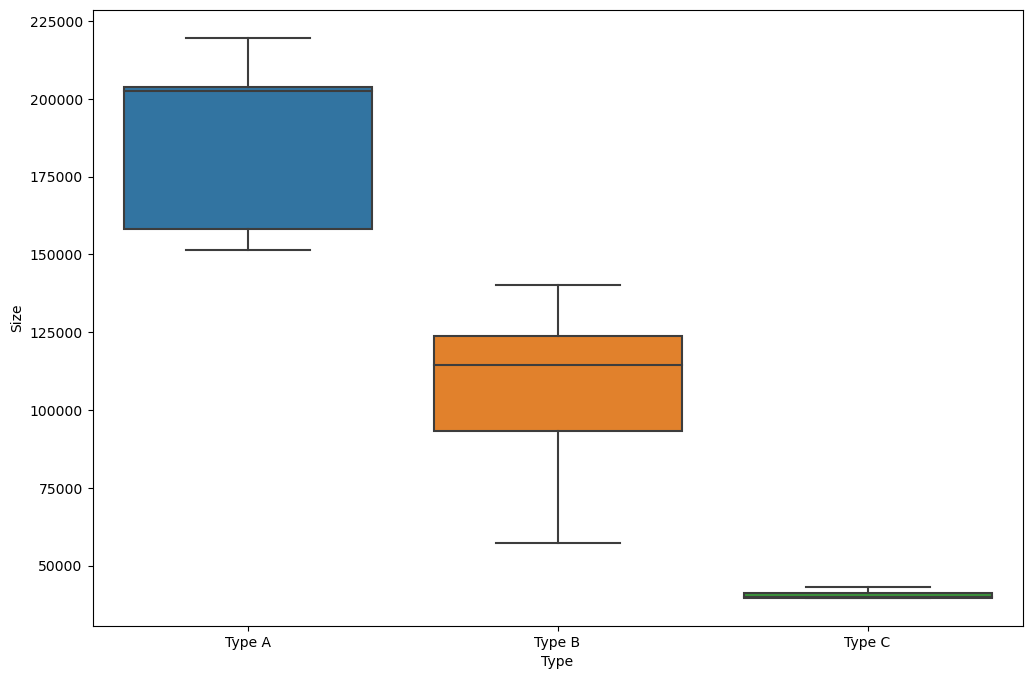

In [14]:
plt.figure(figsize = (12,8))
ax = sns.boxplot(x = 'Type', y ='Size', data = df, showfliers = False)
ax.set_xticklabels(stores)
plt.show()

Using the box plots to investigate the distribution of weekly sales for each store type we can see that A's weekly sales are higher than those of B and C.

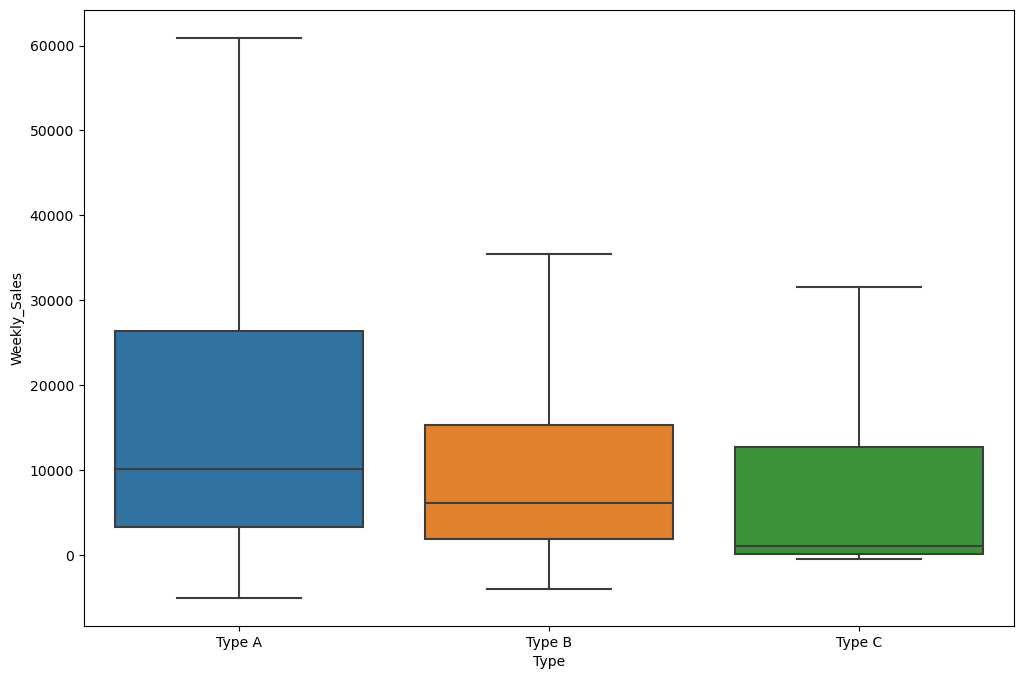

In [15]:
plt.figure(figsize = (12,8))
ax = sns.boxplot(x = 'Type', y ='Weekly_Sales', data = df, showfliers = False)
ax.set_xticklabels(stores)
plt.show()


Exploring how holidays affect the sales of each store reveals that holidays have no significant impact on weekly sales data.

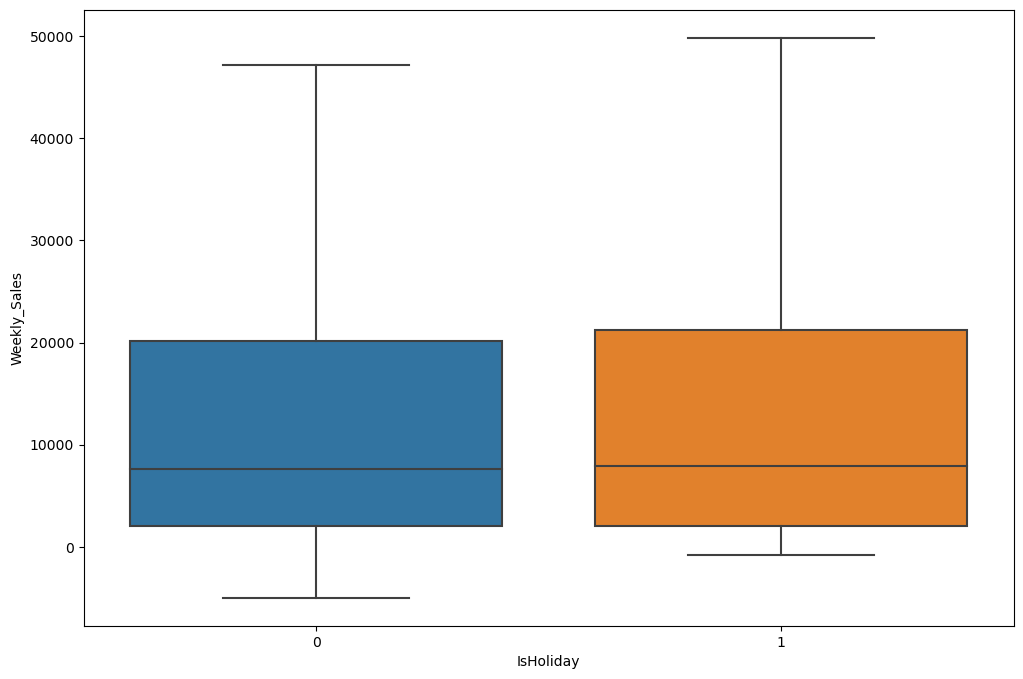

In [16]:
plt.figure(figsize = (12,8))
ax = sns.boxplot(x = 'IsHoliday', y ='Weekly_Sales', data = df, showfliers = False)
plt.show()

Visualize the ***Temperature***, ***Fuel_Price***, ***CPI***, ***Unemployment***, ***MarkDown1***, ***MarkDown2***, ***MarkDown3***, ***MarkDown4***, and ***MarkDown5*** variables to see if we can spot some trends.
We are visualizing the mean against each parameter.

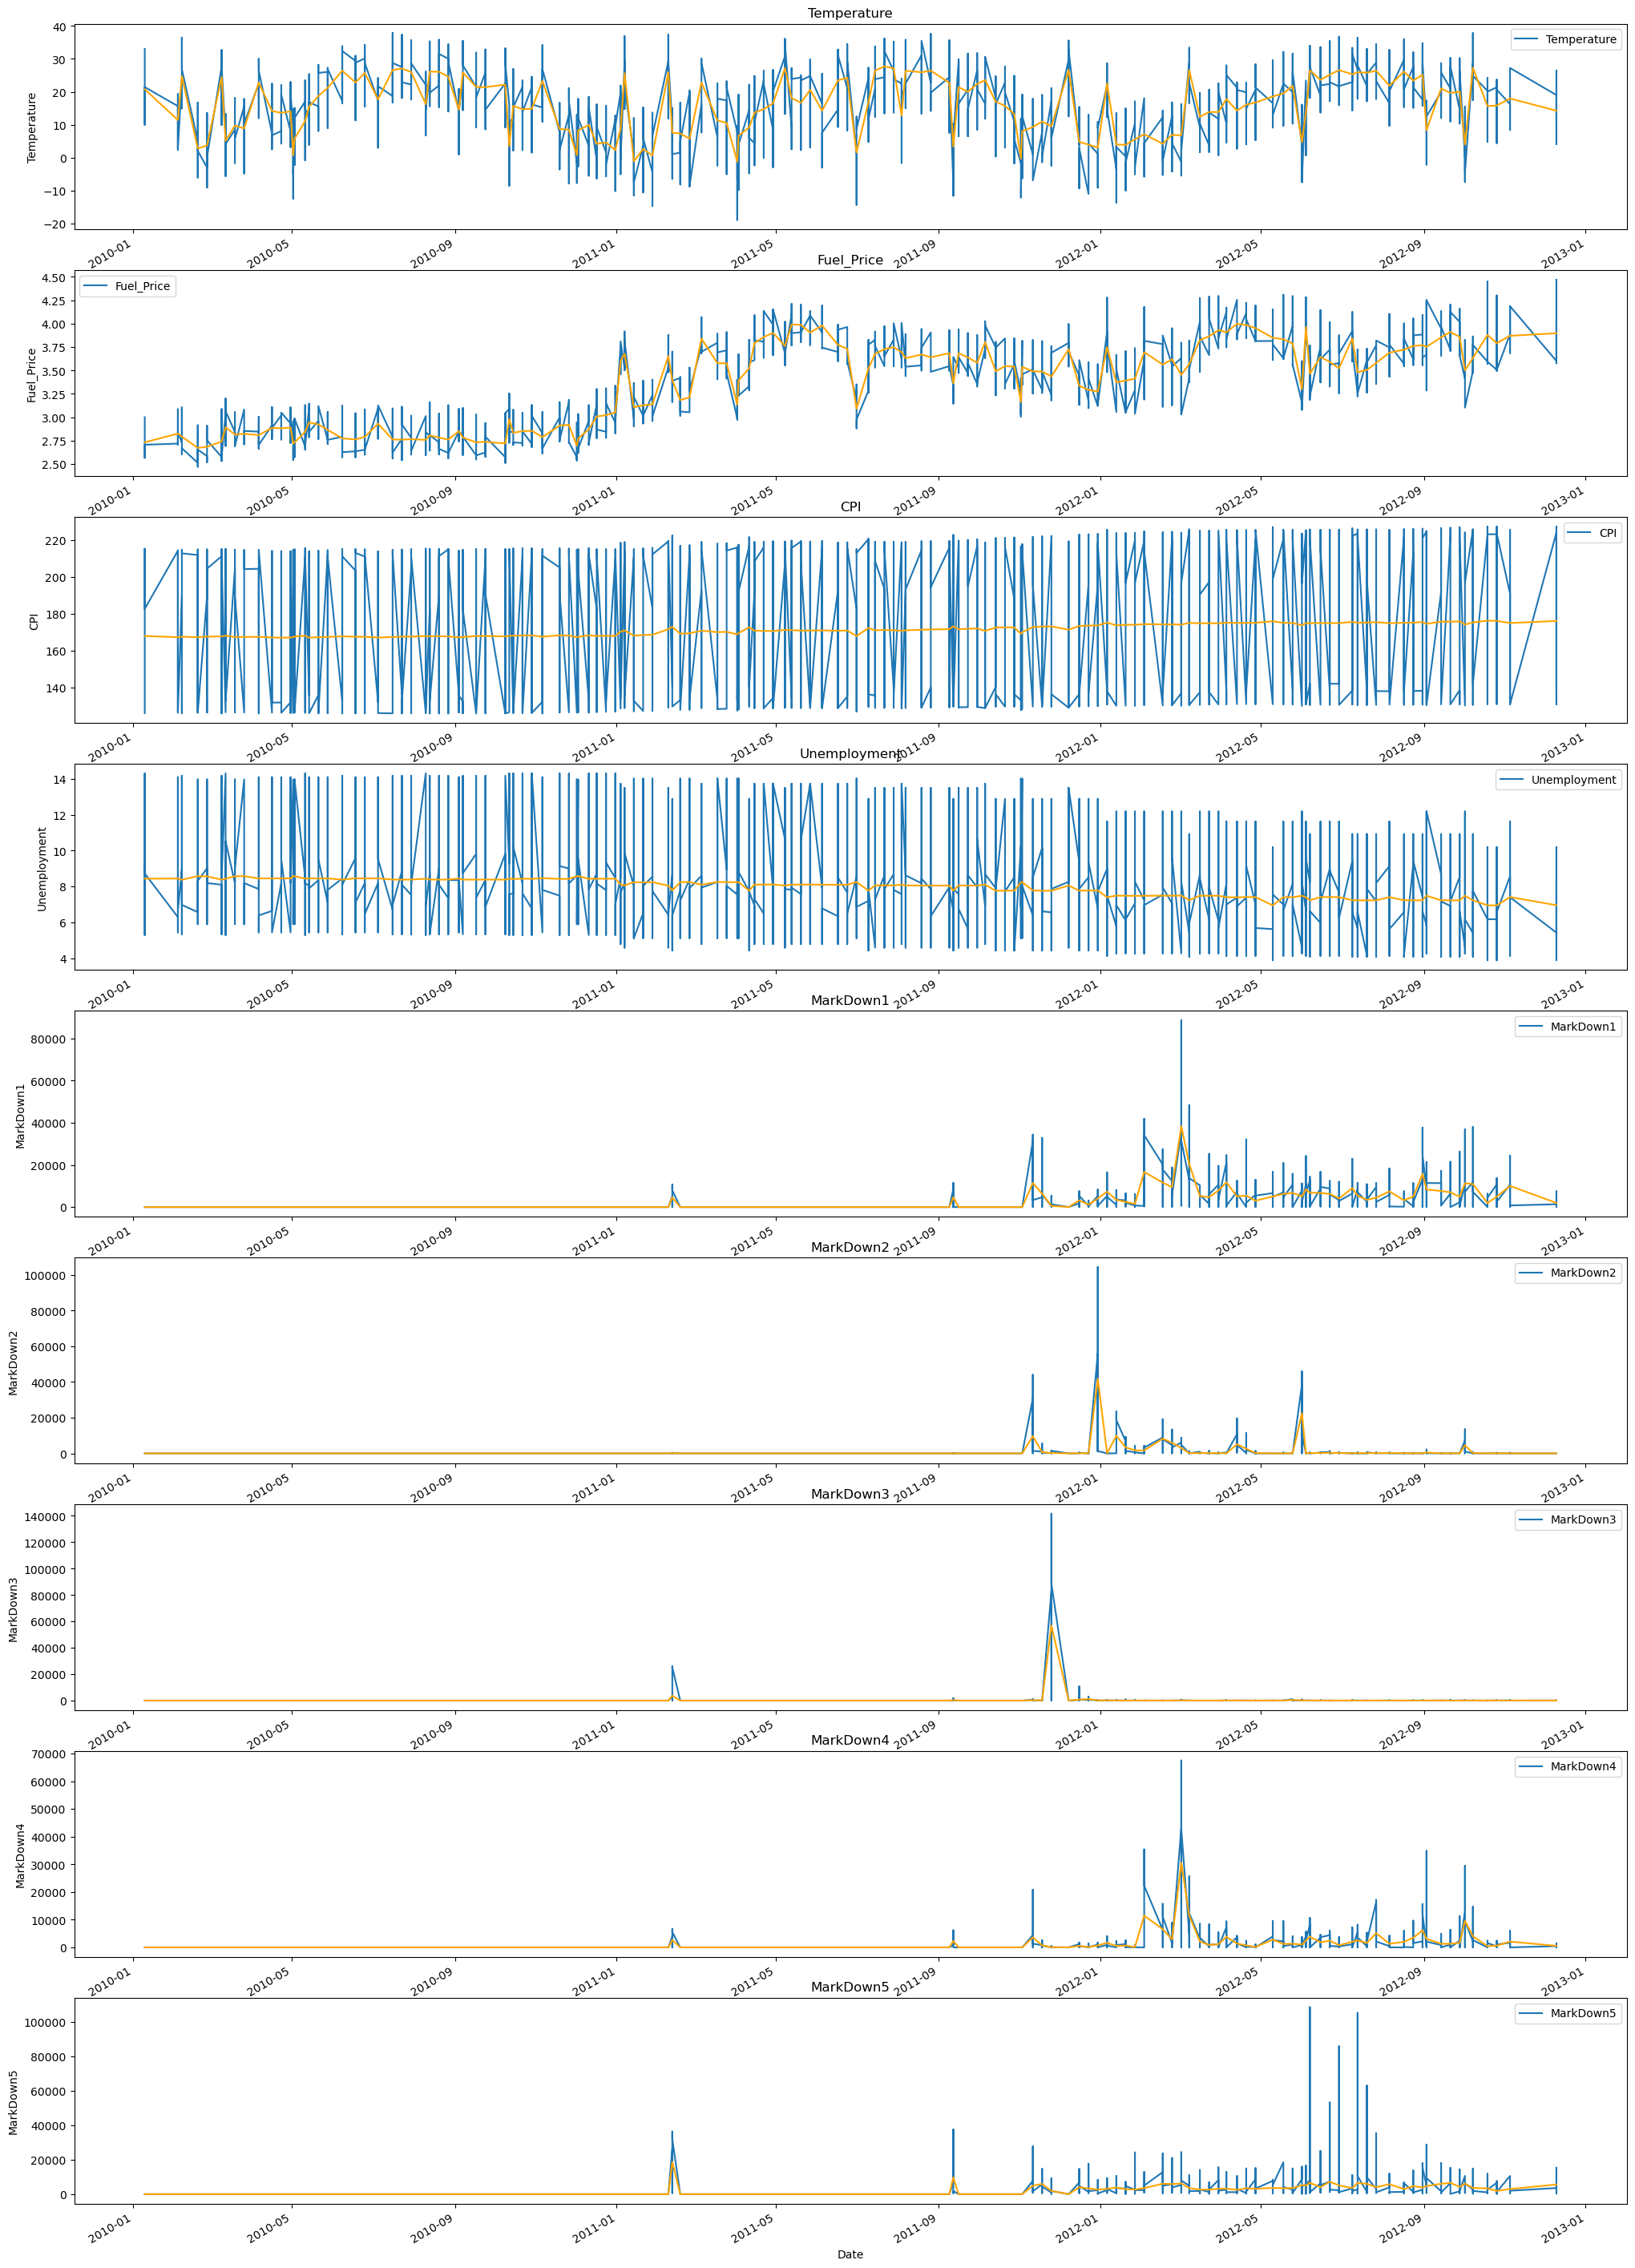

In [17]:

cols = ['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
fig, axes = plt.subplots(len(cols)-1, 1, figsize=(25, 40))
for i, col in enumerate(cols[1:]):
    df.plot(x='Date', y=col, ax=axes[i])
    df.groupby('Date')[col].mean().plot(ax=axes[i], color='orange')
    axes[i].set_title(col)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    
plt.show()

Using a heatmap to analyze the association between numerical characteristics and weekly sales, we can observe that weekly sales have the highest correlation of 0.24 with shop size, which is consistent with our earlier findings.

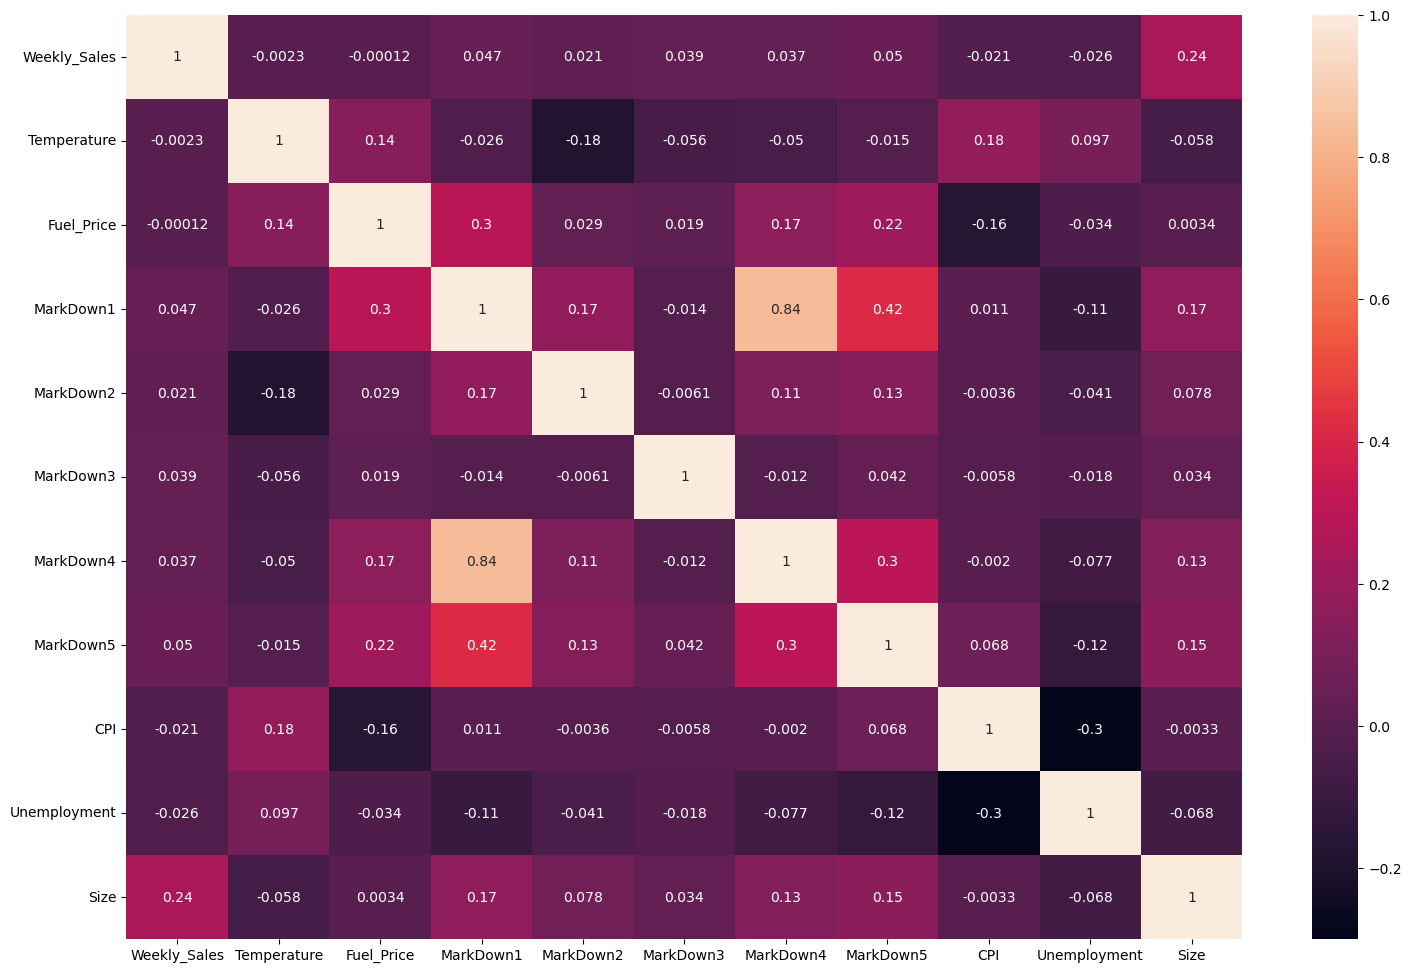

In [18]:
cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Size']
plt.figure(figsize = (18,12))
sns.heatmap(df[cols].corr(), annot = True)
plt.show()

### Data preparation
In this phase, we will use the StandardScaler to scale the features. Feature scaling is crucial in machine learning because it helps to bring all of the features to a comparable size, which can aid in model convergence and enhance overall model performance.

We will also split data in 20% test data and 80% training data

In [19]:
standard_scaler = StandardScaler()
feature_cols = ['Temperature', 'Fuel_Price', 'MarkDown1','MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size']
transformed_features = standard_scaler.fit_transform(df[feature_cols])
df[feature_cols] = transformed_features

#Data splitting on an 80/20 basis
feature_cols  = df.columns.tolist()
#First, define a list called feature_cols that contains all column names from 
#df except for 'Date' and 'Weekly_Sales'. These columns are the 
#independent variables or features used to predict the target variable 'Weekly_Sales'.
feature_cols = [i for i in feature_cols if i not in ['Date', 'Weekly_Sales']]
#The train_test_split function takes the following arguments:
#df[feature_cols]: the independent variables or features
#df['Weekly_Sales']: the dependent variable or target
#test_size = 0.2: the proportion of data to be used for testing (in this case, 20%)
#random_state = 4921: a seed value for the random number generator, to ensure that the split is reproducible.
x_train, x_test, y_train, y_test = train_test_split(df[feature_cols], df['Weekly_Sales'], test_size = 0.2, random_state = 4921)

### Develop ML Models
In this project, we will begin with KNeighborsRegressor, but it often takes multiple attempts with various machine learning algorithms to obtain the desired outcomes. We will use coefficient of determination (accuracy score or r-squared score), mean absolute error (MAE), and root mean squared error (RMSE) scores to evaluate and compare the performance of the machine learning models.

#### Using KNeighborsRegressor

In [25]:
knn_regressor = KNeighborsRegressor(n_neighbors = 10, n_jobs = 10)
knn_regressor.fit(x_train, y_train)
y_pred = knn_regressor.predict(x_test)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Score: {knn_regressor.score(x_test, y_test)}')

MAE: 8768.995933842543
RMSE: 14741.682787811045
Score: 0.5701874049880828


Our findings yielded a score of.57. When we plot this on a line graph, we see that the predictions and observed values have a poor correlation.

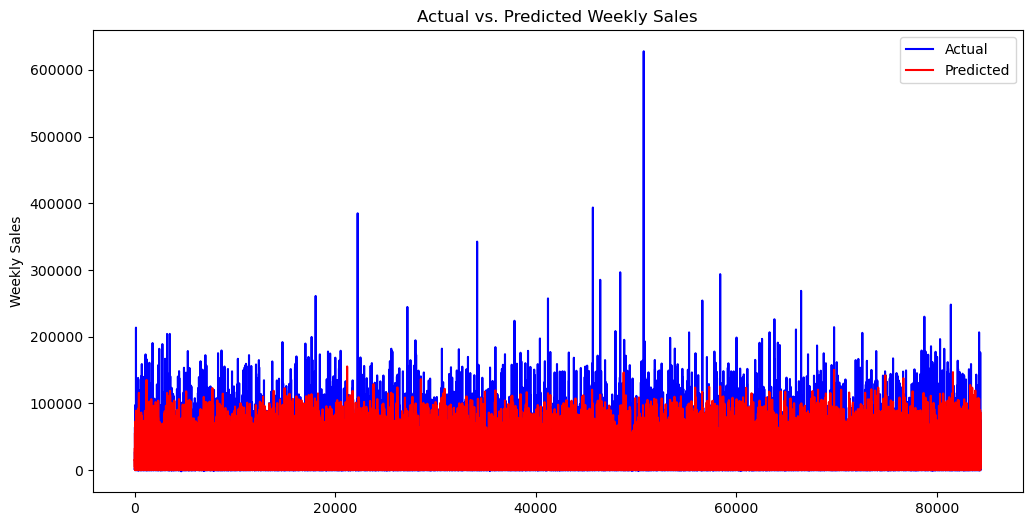

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=range(len(y_test)), y=y_test, ax=ax, label='Actual', color='blue')
sns.lineplot(x=range(len(y_test)), y=y_pred, ax=ax, label='Predicted', color='red')
ax.set_ylabel('Weekly Sales')
ax.set_title('Actual vs. Predicted Weekly Sales')
ax.legend()
plt.show()

#### Using DecisionTreeRegressor

Because we did not yield disirable results with k-nearest we've moved on to decision tree regressor. 
Below are some reasons why we would choose to use a decision tree regressor instead of a k-nearest neighbors regressor:

- Non-linear relationships: Decision trees can model non-linear relationships between the features and the target variable, while k-nearest neighbors regression assumes a linear relationship between the features and the target variable.

- Interpretable: Decision trees are easy to interpret and understand. You can visualize the tree structure and see how the decisions are made based on the features.

- Outlier handling: Decision trees can handle outliers effectively. K-nearest neighbors regressors may be sensitive to outliers because they rely on the nearest neighbors to make predictions.



In [27]:
decision_tree_regressor = DecisionTreeRegressor(random_state=4921)
decision_tree_regressor.fit(x_train, y_train)
y_pred = decision_tree_regressor.predict(x_test)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Score: {decision_tree_regressor.score(x_test, y_test)}')

MAE: 2055.3751643855117
RMSE: 5360.351181533557
Score: 0.9431708054642934


Great improvement. We've managed to improve our model from .57 to .94. There is still room for improvement, let us try another algorithim.

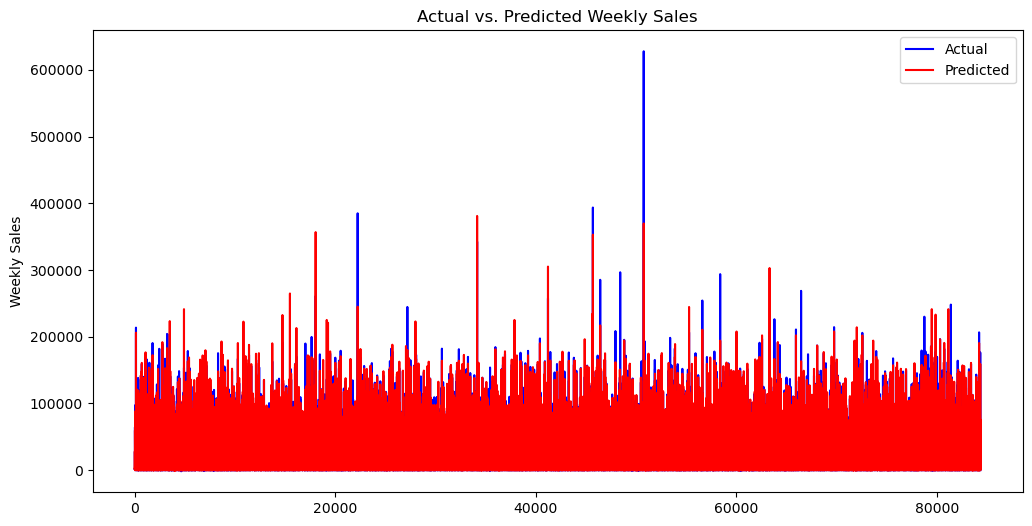

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=range(len(y_test)), y=y_test, ax=ax, label='Actual', color='blue')
sns.lineplot(x=range(len(y_test)), y=y_pred, ax=ax, label='Predicted', color='red')
ax.set_ylabel('Weekly Sales')
ax.set_title('Actual vs. Predicted Weekly Sales')
ax.legend()
plt.show()

#### RandomForestRegressor

In [29]:
rf_regressor = RandomForestRegressor(n_estimators = 500, max_depth = 20, random_state = 4921, n_jobs = 10)
rf_regressor.fit(x_train, y_train)
y_pred = rf_regressor.predict(x_test)

print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Score: {rf_regressor.score(x_test, y_test)}')

MAE: 1607.5863103617162
RMSE: 4013.423315904465
Score: 0.9681422607856733


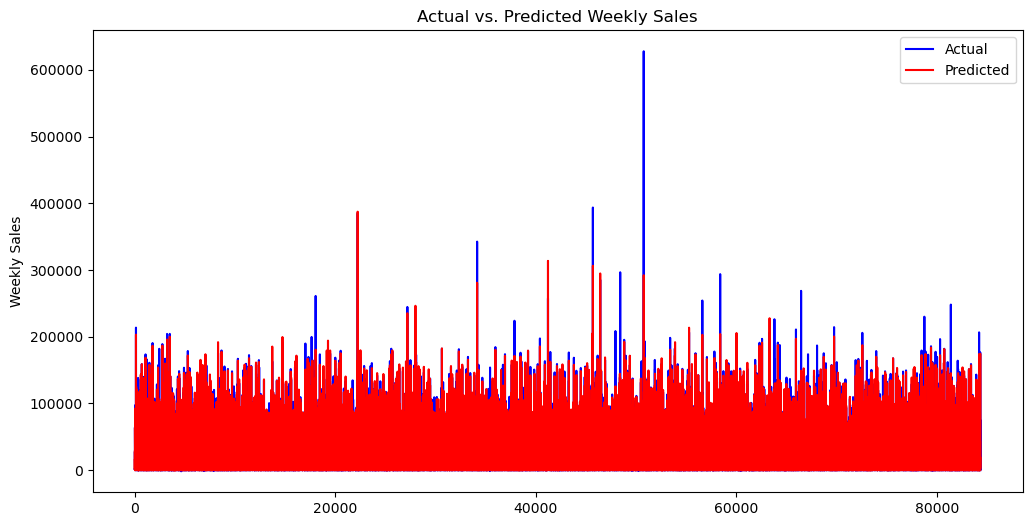

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=range(len(y_test)), y=y_test, ax=ax, label='Actual', color='blue')
sns.lineplot(x=range(len(y_test)), y=y_pred, ax=ax, label='Predicted', color='red')
ax.set_ylabel('Weekly Sales')
ax.set_title('Actual vs. Predicted Weekly Sales')
ax.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [500, 700],
    'max_depth': [5, 7],
    'learning_rate': [0.3, 0.5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

grid_search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=4921),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

xgb_regressor = XGBRegressor(objective = 'reg:squarederror', n_estimators = 700, max_depth = 6, nthread = 10, learning_rate = 0.4, random_state = 4921)
xgb_regressor.fit(x_train, y_train)
grid_search = xgb_regressor.predict(x_test)

#print(f'Best params: {grid_search.best_params_}')
print(f'MAE: {metrics.mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}')
print(f'Score: {grid_search.score(x_test, y_test)}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=range(len(y_test)), y=y_test, ax=ax, label='Actual', color='blue')
sns.lineplot(x=range(len(y_test)), y=y_pred, ax=ax, label='Predicted', color='red')
ax.set_ylabel('Weekly Sales')
ax.set_title('Actual vs. Predicted Weekly Sales')
ax.legend()
plt.show()